In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick

In [21]:
TICKER = 'SPY'
MFI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
RSI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):

    # get data at interval you want
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]


    return df

def add_MFI(df, length=14, overbought=80, oversold=20):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_RSI(df, length = RSI_LENGTH):
    price_change = df['Close'].diff()

    #Separate out gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change <0, 0)

    #average gains vs losses
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #Relative Strength - what percentage of eachother have the gains and losses been
    rs = avg_gain/avg_loss

    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    #Plot RSI
    plt.figure(figsize=(12, 6))
    plt.plot(df['RSI'], label='RSI')
    plt.axhline(OVERBOUGHT, color='red', linewidth=1, linestyle='--', label = 'Overbought')
    plt.axhline(OVERSOLD, color='green', linewidth=1, linestyle='--', label = 'Oversold')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df.dropna()

In [22]:
def add_RSI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df
    
def add_MFI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

    
def add_full_strategy(df):

    df['Full_Strategy'] = df['MFI_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))
    return df


C:\Users\EWD\AppData\Local\Temp\ipykernel_26316\3402816073.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


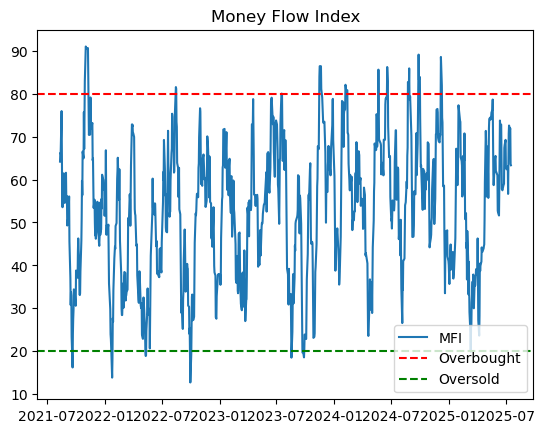

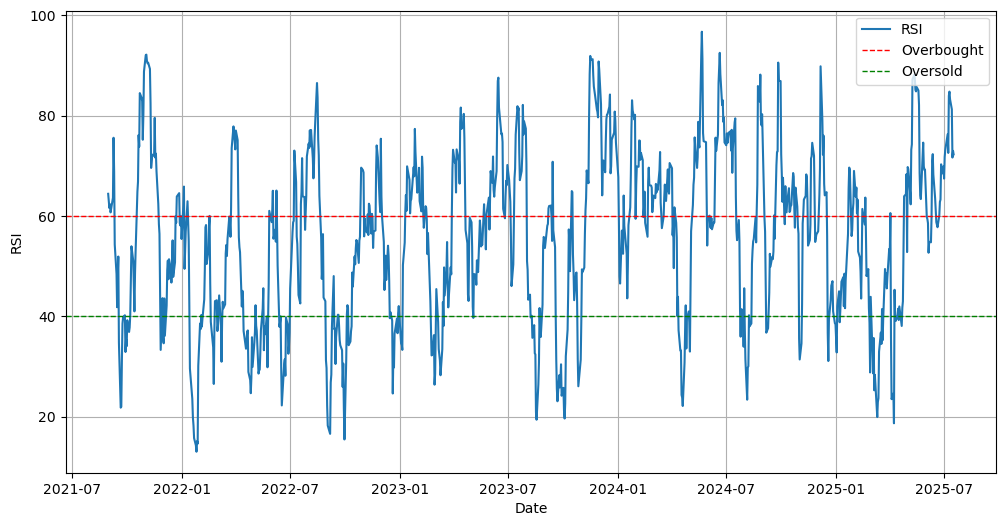

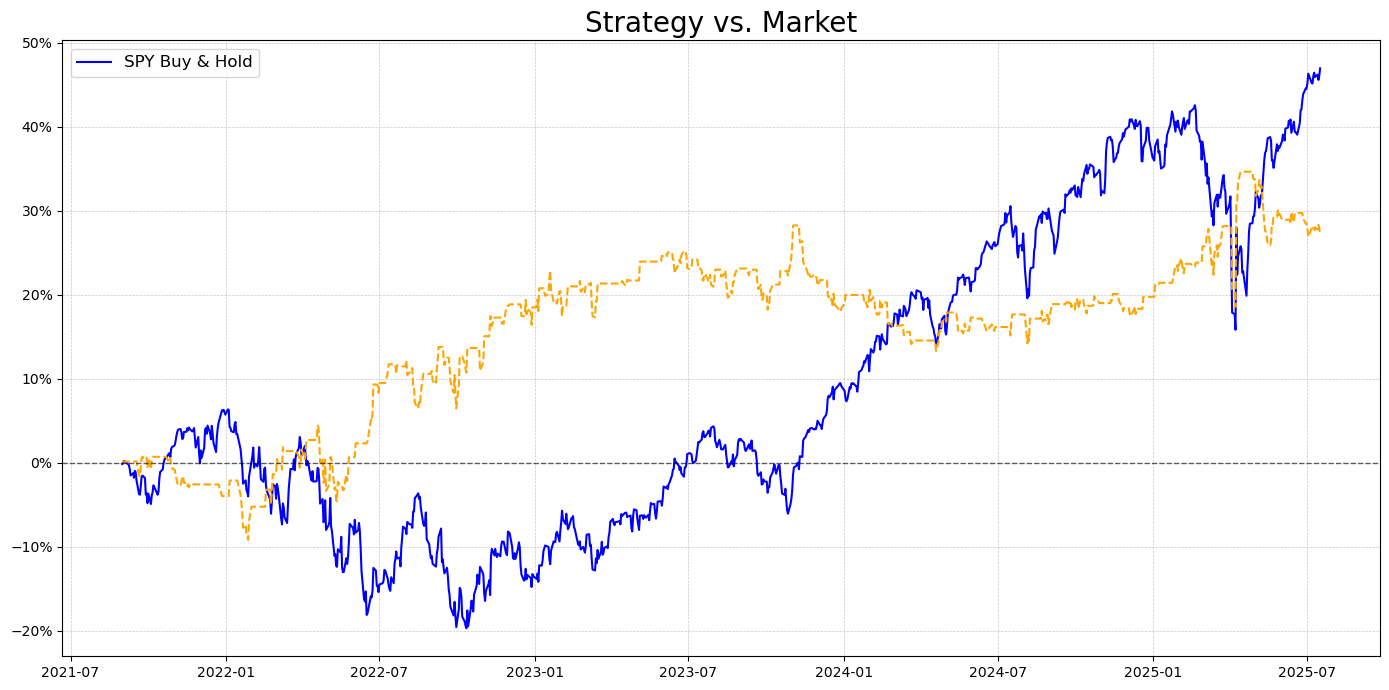

SPY Price Change: 46.96%
SPY Strategy Return: 27.12%


Price,Close,High,Low,Open,Volume,Typical_Price,Raw_Money_Flow,Price_Change,Pos_Flow,Neg_Flow,MFI,RSI,MFI_Strategy,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,,,,,
2021-08-30,427.351349,428.145134,425.914951,426.160656,48357400,427.137145,2.065524e+10,2.535699,2.065524e+10,0.000000e+00,61.581038,64.405180,NaN,NaN,NaN,0,NaN,NaN
2021-08-31,426.718201,427.597031,426.113424,427.256850,59300200,426.809552,2.530989e+10,-0.327592,0.000000e+00,2.530989e+10,55.429864,62.966774,-1.0,-1.0,-2.0,-1,-0.001482,0.001482
2021-09-01,426.944977,428.182907,426.708730,427.663176,48721400,427.278871,2.081762e+10,0.469319,2.081762e+10,0.000000e+00,55.964981,61.570504,0.0,-1.0,-1.0,0,-0.000951,0.001482
2021-09-02,428.258575,429.071250,427.048993,428.381428,42501000,428.126273,1.819579e+10,0.847402,1.819579e+10,0.000000e+00,56.149942,62.326332,0.0,-1.0,-1.0,0,0.002123,0.001482
2021-09-03,428.154663,428.674423,426.708834,427.115201,47170500,427.845974,2.018171e+10,-0.280300,0.000000e+00,2.018171e+10,49.292154,60.700704,0.0,-1.0,-1.0,0,0.001880,0.001482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200,623.336670,3.968797e+10,-1.896667,0.000000e+00,3.968797e+10,72.575558,83.235203,-1.0,-1.0,-2.0,-1,0.459268,0.280280
2025-07-14,624.809998,625.159973,621.799988,623.159973,51898500,623.923319,3.238068e+10,0.586650,3.238068e+10,0.000000e+00,71.645315,81.246877,-1.0,-1.0,-2.0,-1,0.462052,0.277837
2025-07-15,622.140015,627.859985,622.059998,627.520020,74317300,624.019999,4.637548e+10,0.096680,4.637548e+10,0.000000e+00,71.900986,71.633857,-1.0,-1.0,-2.0,-1,0.455804,0.283298


In [23]:
def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure(figsize=(14, 7))
    plt.plot(df['Asset_Returns'],label=f'{TICKER} Buy & Hold', color='blue', linewidth=1.5)
    plt.plot(df['Strategy_Returns'], color='orange',linestyle='--', linewidth=1.5)
    plt.legend([f'{TICKER} Cumulative', 'Strategy Cumulative'])
    plt.title('Strategy vs. Market', size='20')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    return df

def return_summary(df, TICKER, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Price Change: {asset_return:.2f}%")
    print(f"{TICKER} Strategy Return: {strategy_return:.2f}%")
    return df

def main():
    df = get_data()
    df = add_MFI(df)
    df = add_RSI(df)
    df = add_MFI_strategy(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)  
    return df

main()